In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import keras

data_dir = ""
model_dir = ""
figure_dir = ""

def load_body_data():
    train : dict[str, np.ndarray] = dict()
    test  : dict[str, np.ndarray] = dict()

    train["img"] = np.load(data_dir+"body_train_X1.npy")
    train["sexs"] = np.load(data_dir+"body_sex_train.npy")
    train["ages"] = np.load(data_dir+"body_age_train.npy")
    train["labels"] = np.load(data_dir+"body_train_y.npy")
    test["img"] = np.load(data_dir+"body_test_X1.npy")
    test["sexs"] = np.load(data_dir+"body_sex_test.npy")
    test["ages"] = np.load(data_dir+"body_age_test.npy")
    test["labels"] = np.load(data_dir+"body_test_y.npy")

    return train, test

def split_face_data(train, test, key="img"):

    X = train[key]
    y = train["ages"].reshape(-1).astype(np.int32)

    test_X = test[key]
    test_y = test["ages"].reshape(-1).astype(np.int32)

    indices = np.arange(len(X))
    np.random.seed(123)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    train_img = X[:int(len(X)*0.8)]
    train_labels = y[:int(len(X)*0.8)]
    valid_img = X[int(len(X)*0.8):]
    valid_labels = y[int(len(X)*0.8):]


    t_total  = len(train_labels)
    t_P = train_labels.sum()
    t_N = t_total - t_P

    v_total = len(valid_labels)
    v_P = valid_labels.sum()
    v_N = v_total - v_P

    print("X_train shape:", train_img.shape)
    print("y_train shape:", train_labels.shape)
    print("X_val shape:", valid_img.shape)
    print("y_val shape:", valid_labels.shape)
    print("train P:{:.4f}, N:{:.4f}, total:{}".format(t_P/t_total, t_N/t_total, t_total))
    print("valid P:{:.4f}, N:{:.4f}, total:{}".format(v_P/v_total, v_N/v_total, v_total))

    return train_img, train_labels, valid_img, valid_labels, test_X, test_y

In [ ]:
# @title evaluate
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn


class evaluate:
  def __init__(self, labels, predict, val_labels, val_predict, sex, age):
    self.labels = labels.squeeze()
    self.predict = predict.squeeze()
    self.val_labels = val_labels.squeeze()
    self.val_predict = val_predict.squeeze()
    self.figsize = (10, 10)
    self.threshold = 0.5
    self.sex = sex
    self.age = age

  def set_threshold(self):
    # calculate Youden’s index in valid set
    val_label = self.val_labels.squeeze()
    val_predict = self.val_predict.squeeze()
    def calculate_Y_index(threshold):
      TP = np.logical_and(val_label >= threshold, val_predict >= threshold).sum()
      TN = np.logical_and(val_label < threshold, val_predict <  threshold).sum()
      FP = np.logical_and(val_label < threshold, val_predict >= threshold).sum()
      FN = np.logical_and(val_label >= threshold, val_predict <  threshold).sum()

      assert TP + FN + TN + FP == len(val_label)
      assert TP + FN == val_label.sum()
      assert TN + FP == len(val_label) - val_label.sum()
      Sensitivity = TP / (TP + FN)
      Specificity = TN / (FP + TN)
      return Sensitivity + Specificity

    thresholds = np.sort(val_predict)[1:-1]
    y = np.vectorize(calculate_Y_index)(thresholds)
    self.threshold = thresholds[np.argmax(y)]


  def result(self, labels, predict):
    if len(labels) == 0 or len(scores) == 0:
      labels = self.labels
      predict = self.predict

    labels = labels.squeeze()
    predict = predict.squeeze()
    assert len(labels) == len(predict)

    threshold = self.threshold

    acc = accuracy_score(labels, predict>=threshold)
    auc = roc_auc_score(labels, predict)

    acc = round(acc, 4)
    auc = round(auc, 4)

    print(labels.shape, predict.shape)
    cm = confusion_matrix(labels, predict >= self.threshold)
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]

    print(f"{TP=}, {TN=}, {FP=}, {FN=}")


    assert TP + FN == labels.sum()
    assert TN + FP == labels.shape[0] - labels.sum()

    Sensitivity = round(TP / (TP + FN), 4)
    Specificity = round(TN / (FP + TN), 4)
    if TP + FP == 0 or TN + FN == 0:
      PPV = None
      NPV = None
    else:
      PPV = round(TP / (TP + FP), 4)
      NPV = round(TN / (TN + FN), 4)

    return (Sensitivity, Specificity, PPV, NPV, acc, auc)
def group_age_sex(arr, age, sex):

    predict_0_19 =  arr[age<20]
    predict_20_39 = arr[np.logical_and(age>=20, age <40)]
    predict_40_59 = arr[np.logical_and(age>=40, age <60)]
    predict_60 = arr[age>=60]
    predict_20 = arr[age>=20]
    predict_M = arr[sex=='남']
    predict_F = arr[sex=='여']

    return (predict_0_19, predict_20_39, predict_40_59, predict_60, predict_20, predict_M, predict_F)


In [ ]:
# @title plot functions
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn

def plot_cm(labels, predictions, p=0.5, **kwargs):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d",**kwargs)
  #plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual Values', fontsize=20)
  plt.xlabel('Predicted Values', fontsize=20)

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_roc(name, labels, predictions, **kwargs):

  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  plt.plot(100*fp, 100*tp, label=name, linewidth=4, **kwargs)
  plt.xlabel('False positives', fontsize=20)
  plt.ylabel('True positives', fontsize=20)
  plt.grid(True)
  plt.xlim(0, 100)
  plt.ylim(0, 100)
  plt.axis("off")
  ax = plt.gca()
  ax.set_aspect(aspect=1)


In [ ]:
# @title load data and split and load model
import os
import numpy as np

train, test = load_body_data()
train_img, train_labels, valid_img, valid_labels, test_X, test_y = split_face_data(train, test)

test_ages = test['ages']
test_sexs = test['sexs']


X_train shape: (1121, 608, 224, 3)
y_train shape: (1121,)
X_val shape: (281, 608, 224, 3)
y_val shape: (281,)
train P:39.6690, N:-38.6690, total:1121
valid P:43.1566, N:-42.1566, total:281


In [ ]:
import tensorflow as tf
img_height = 608
img_width = 224
img_size = (img_height, img_width, 3)
train_ds = tf.data.Dataset.from_tensor_slices((train_img, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((valid_img, valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)


In [ ]:
from tensorflow import keras
from tensorflow.keras import regularizers

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc',num_thresholds=1000),
]




In [ ]:
neg = 69
pos = 212
total = neg+pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 2.04
Weight for class 1: 0.66


In [ ]:
pos/total


0.7544483985765125

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2, l1, L1L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers


def get_vgg16(img_size, output_bias= None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    inputs = keras.Input(shape=img_size)
    x = keras.applications.vgg16.preprocess_input(inputs)
    x = keras.applications.VGG16(input_tensor=x,
                               include_top=False,
                               weights="imagenet")
    x.trainable = False

    x = layers.Flatten()(x.output)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=L1L2(l1=0.005, l2=0.005))(x)
    outputs = keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(l2=0.001), bias_initializer=output_bias)(x)
    return  keras.Model(inputs, outputs)


In [ ]:

data_augmentation = keras.Sequential([
    layers.RandomZoom(0.05, fill_mode="nearest"),
    # layers.RandomCrop(224, 224),
    layers.GaussianDropout(0.005),
    layers.RandomBrightness((-0.01, 0.01), value_range=(0, 255)),
])
train_ds_augmented = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(
        tf.data.AUTOTUNE)



255.0 0.0 float32


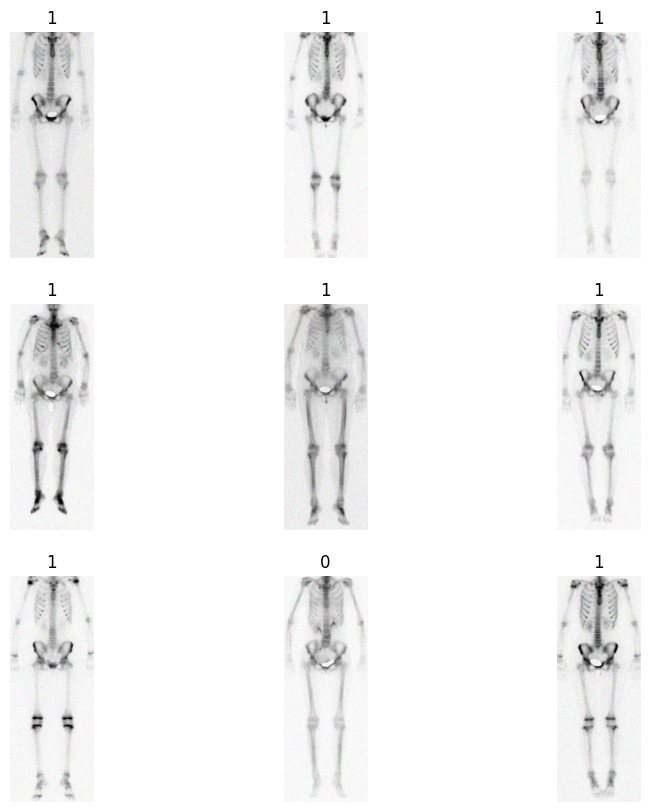

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for _, (img, label) in enumerate(train_ds_augmented.take(1)):
    print(img.numpy().max(), img.numpy().min(), img.numpy().dtype)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        plt.imshow(img[i].numpy().astype(np.uint8), cmap ='gray')
        plt.title(int(label[i]))
        plt.axis("off")

In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

array([1.12247977])

In [ ]:
model = get_vgg16((608, 224, 3), output_bias=initial_bias)
optimizer = Adam(learning_rate=5e-4)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=METRICS
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_filepath = './tmp/checkpoint.weights'
callbacks=[ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_auc',
            mode='max',
            save_best_only=True),
            ]

In [ ]:
initial_epoch = 15
history = model.fit(train_ds_augmented, epochs=initial_epoch, validation_data=val_ds, class_weight=class_weight, callbacks=callbacks)

Epoch 1/15
36/36 [==============================] - 81s 2s/step - loss: 153.5761 - accuracy: 0.5781 - auc: 0.5511 - val_loss: 53.4106 - val_accuracy: 0.7544 - val_auc: 0.6265
Epoch 2/15
36/36 [==============================] - 41s 1s/step - loss: 34.7801 - accuracy: 0.6182 - auc: 0.6437 - val_loss: 23.2057 - val_accuracy: 0.7224 - val_auc: 0.6416
Epoch 3/15
36/36 [==============================] - 42s 1s/step - loss: 18.7173 - accuracy: 0.5674 - auc: 0.6301 - val_loss: 15.1002 - val_accuracy: 0.7687 - val_auc: 0.6431
Epoch 4/15
36/36 [==============================] - 54s 2s/step - loss: 13.2192 - accuracy: 0.6209 - auc: 0.6669 - val_loss: 11.3901 - val_accuracy: 0.7544 - val_auc: 0.6455
Epoch 5/15
36/36 [==============================] - 41s 1s/step - loss: 10.7837 - accuracy: 0.5950 - auc: 0.6437 - val_loss: 9.7791 - val_accuracy: 0.7544 - val_auc: 0.6379
Epoch 6/15
36/36 [==============================] - 40s 1s/step - loss: 9.1929 - accuracy: 0.6120 - auc: 0.6693 - val_loss: 8.2645

In [ ]:
# model.load_weights(checkpoint_filepath)
train_results = model.evaluate(train_ds)
test_results = model.evaluate(test_ds)
print("         train | test")
for name, train_value, test_value in zip(model.metrics_names, train_results, test_results):
  print("{:8s} {:.4f}, {:.4f}".format(name, train_value, test_value))
print()

14/14 [==============================] - 5s 356ms/step - loss: 11.3994 - accuracy: 0.7404 - auc: 0.6614
         train | test
loss     11.3725, 11.3994
accuracy 0.7565, 0.7404
auc      0.7289, 0.6614



In [ ]:

model.save(model_dir+"freeze_body")

In [ ]:
model = keras.models.load_model(model_dir+"freeze_body")

In [ ]:
print("Number of layers in the base model: ", len(model.layers))
model.trainable = True

Number of layers in the base model:  25


In [ ]:
# for layer in model.layers[:-8]:
#     layer.trainable = False
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 608, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 608, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 608, 224, 3)       0         
 da)                                                             
                                                                 
 block1_conv1 (Conv2D)       (None, 608, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 608, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 304, 112, 64)      0   

In [ ]:
model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-5),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=METRICS)
initial_epoch = 15
total_epoch = initial_epoch + 10
history_fined = model.fit(train_ds_augmented, epochs=total_epoch,
                          initial_epoch=initial_epoch,
                          validation_data=val_ds, callbacks=callbacks, class_weight=class_weight)

In [ ]:
# model.load_weights(checkpoint_filepath)
train_results = model.evaluate(train_ds)
test_results = model.evaluate(test_ds)
print("         train | test")
for name, train_value, test_value in zip(model.metrics_names, train_results, test_results):
  print("{:8s} {:.4f}, {:.4f}".format(name, train_value, test_value))
print()


14/14 [==============================] - 5s 376ms/step - loss: 5.9029 - accuracy: 0.7494 - auc: 0.6540
         train | test
loss     5.8657, 5.9029
accuracy 0.7752, 0.7494
auc      0.7521, 0.6540



In [ ]:
model.save(model_dir+"new_finetuning_body")